In [83]:
import os
import cv2
import numpy as np
import tensorflow as tf
from skimage import io,transform
from skimage.transform import resize
from matplotlib import pyplot as plt

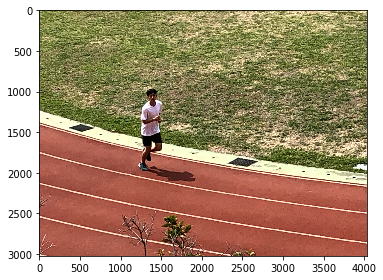

In [84]:
img =io.imread('C://Users//USER//Desktop//train//a//01.jpg')
io.imshow(img)
io.show()

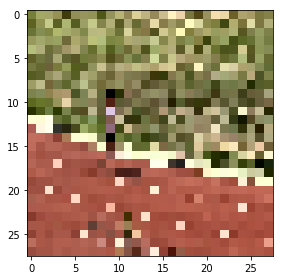

In [85]:
img =io.imread('C://Users//USER//Desktop//train//a//01.jpg')
dst =resize(img, (28, 28))
io.imshow(dst)
io.show()


In [86]:
img.shape

(3024, 4032, 3)

In [87]:
def get_File(file_dir):
    # The images in each subfolder
    images = []
    
    # The subfolders
    subfolders = []

    # Using "os.walk" function to grab all the files in each folder
    for dirPath, dirNames, fileNames in os.walk(file_dir):
        for name in fileNames:
            images.append(os.path.join(dirPath, name))

        for name in dirNames:
            subfolders.append(os.path.join(dirPath, name))

    # To record the labels of the image dataset
    labels = []
    
    for one_folder in subfolders:
        n_img = len(os.listdir(one_folder))
        letter = one_folder.split('/')[-1]
        
        if letter=='a':
            labels = np.append(labels, n_img*[1])
        elif letter=='b':
            labels = np.append(labels, n_img*[2])
        elif letter=='c':
            labels = np.append(labels, n_img*[3])
        else :
            labels = np.append(labels, n_img*[4])

    subfolders = np.array([images, labels])
    subfolders = subfolders.transpose()

    image_list = list(subfolders[0])
    label_list = list(subfolders[1])
    label_list = [int(float(i)) for i in label_list]
    return image_list, label_list

In [88]:
# 轉Int64資料為 tf.train.Feature 格式
def int64_feature(value):
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

# 轉Bytes資料為 tf.train.Feature 格式
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert_to_TFRecord(images, labels, filename):
    n_samples = len(labels)
    TFWriter = tf.python_io.TFRecordWriter(filename)

    print('\nTransform start...')
    for i in np.arange(0, n_samples):
        try:
            image = io.imread(images[i])
            image =resize(image, (28, 28))

            if image is None:
                print('Error image:' + images[i])
            else:
                image_raw = image.tostring()

            label = int(labels[i])
            
            # 將 tf.train.Feature 合併成 tf.train.Features
            ftrs = tf.train.Features(
                    feature={'Label': int64_feature(label),
                             'image_raw': bytes_feature(image_raw)}
                   )
        
            # 將 tf.train.Features 轉成 tf.train.Example
            example = tf.train.Example(features=ftrs)

            # 將 tf.train.Example 寫成 tfRecord 格式
            TFWriter.write(example.SerializeToString())
        except IOError as e:
            print('Skip!\n')

    TFWriter.close()
    print('Transform done!')

In [89]:
def main():
    # 資料集的位置
    train_dataset_dir = 'C://Users//USER//Desktop//train//'
    save_dir = 'C://Users//USER//Desktop//train//Train.tfrecords'
    
    # 取回所有檔案路徑
    images, labels = get_File(train_dataset_dir)
    
    # 開始寫入 TRRecord 檔案
    convert_to_TFRecord(images, labels, save_dir)

if __name__ == '__main__':
    main()


Transform start...
Skip!

Skip!

Skip!

Skip!

Transform done!


In [90]:
def read_and_decode(tfrecords_file, batch_size):
    filename_queue = tf.train.string_input_producer([tfrecords_file])
    
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    img_features = tf.parse_single_example(
                                        serialized_example,
                                        features={
                                               'Label':tf.FixedLenFeature([], tf.int64),
                                               'image_raw':tf.FixedLenFeature([], tf.string),
                                        })
    image = tf.decode_raw(img_features['image_raw'], tf.uint8)
    
    ###################################
    #調整數據大小
    ###################################
    
    
    image = tf.reshape(image, [80, 80])
    label = tf.cast(img_features['Label'], tf.int32)
    image_batch, label_batch = tf.train.batch([image, label],
                                                batch_size = batch_size,
                                                num_threads = 64,
                                                capacity = 2000)
    return image_batch, tf.reshape(label_batch, [batch_size])



In [91]:
def plot_image(images, labels, title):
    
    for i in np.arrange(0, BATCH_SIZE):
        plt.imshow(image[i])
    plt.show()

In [92]:
# 自己做好的 TF 檔在哪裡，自己知道
tfrecords_file = 'C://Users//USER//Desktop//train//Train.tfrecords'

# batch 可以自由設定
batch_size = 3

image_batch, label_batch = read_and_decode(tfrecords_file, batch_size)

In [93]:
with tf.Session() as sess:
    # 初始化是必要的動作
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    i = 0
    # 建立執行緒協調器
    coord = tf.train.Coordinator()
    
    # 啟動文件隊列，開始讀取文件
    threads = tf.train.start_queue_runners(coord=coord)
    
    try:
        while not coord.should_stop() and i<1:
            
            image, label = sess.run([image_batch, label_batch])
            plot_images(image, label, 'test image')
            i+=1
            
            
    except tf.errors.OutOfRangeError:
        print('Done!')

    finally:
        

    # 結束後記得把文件名隊列關掉
        coord.request_stop() 
    coord.join(threads)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.InvalidArgumentError'>, Input to reshape is a tensor with 18816 values, but the requested shape has 784
	 [[{{node Reshape}} = Reshape[T=DT_UINT8, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](DecodeRaw, Reshape/shape)]]


InvalidArgumentError: Input to reshape is a tensor with 18816 values, but the requested shape has 784
	 [[{{node Reshape}} = Reshape[T=DT_UINT8, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](DecodeRaw, Reshape/shape)]]